---
# CutMix 또는 Mixup 비교실험 하기
---
지금까지 기본적인 augmentation 방법을 적용해 모델을 훈련시키고, 최신 augmentation 기법을 배워 보았습니다.

이번에는 최신 기법(CutMix 또는 Mixup)을 적용해 모델을 훈련시켜 봅시다. 데이터셋에 두 가지 방법 중 하나를 적용하고, 모델을 학습시켜 주세요. 결과를 수치화하고 비교하는 것도 잊지 마세요!

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteBJZJ9N/stanford_dogs-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteBJZJ9N/stanford_dogs-test.tfrecord*...:   0%|   …

Dataset stanford_dogs downloaded and prepared to ~/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [ ]:
NUM_CLASSES = ds_info.features["label"].num_classes
NUM_CLASSES  # 120

120

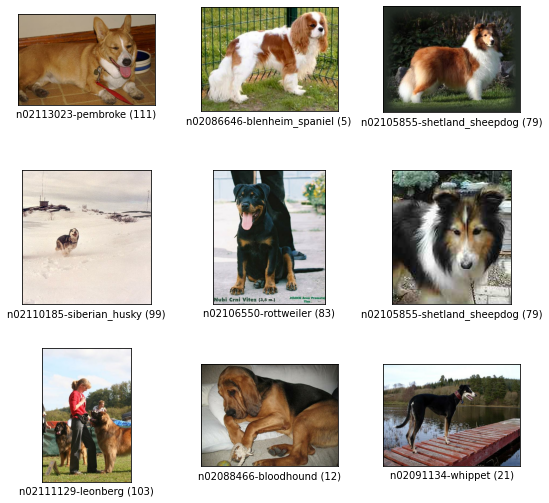

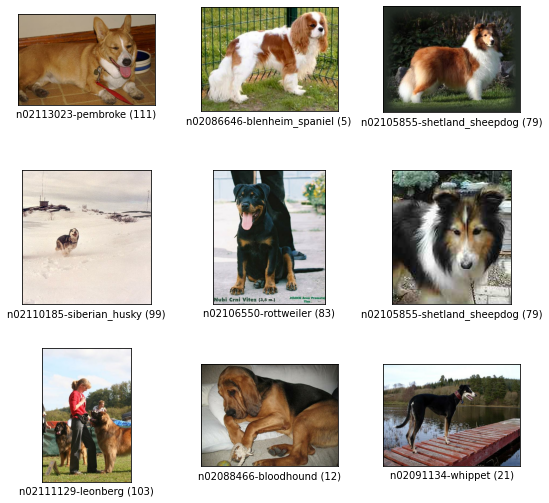

In [ ]:
tfds.show_examples(ds_train, ds_info)

---
## 1. Augmentation을 적용한 데이터셋 만들기
---
이전 스텝과 아래 코드를 참고하여 데이터셋에 CutMix 또는 Mixup augmentation을 적용해 주세요.

이미지 전처리

In [ ]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [ ]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

### Cutmix augmentation

In [ ]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [ ]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [ ]:
# mix two labels
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [ ]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### Mixup augmentation

In [ ]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b, num_classes=120):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [ ]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### augmentation 적용

In [ ]:
# 원핫 인코딩
def onehot(image, label, num_classes=120):
    label_one_hot = tf.one_hot(label, num_classes)
    return image, label_one_hot

In [ ]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img,  # normalizing 과 resizing 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment  # augment 함수 적용
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,  # cutmix augment 함수 적용
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,  # mixup augment 함수 적용
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,  # one - hot encoding
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [ ]:
strategy = tf.distribute.MirroredStrategy()
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

In [ ]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_aug=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_cutmix=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True, batch_size=BATCH_SIZE)


---
## 2. 모델 만들기
---
앞서 만들었던 것처럼 비교 실험을 위한 모델 두 개를 만들어 주세요. 모델은 ResNet-50을 사용합시다.

In [ ]:
def create_ResNet50(include_top=False,
                    weights='imagenet',
                    input_shape=(224,224,3),
                    pooling='avg',
                    num_classes=120,
                    activation='softmax'):
                    
    resnet50 = keras.models.Sequential([
        keras.applications.resnet.ResNet50(
            include_top=include_top,
            weights=weights,
            input_shape=input_shape,
            pooling=pooling,
        ),
        keras.layers.Dense(num_classes, activation=activation)
    ])
    return resnet50

In [ ]:
resnet50_no_aug = create_ResNet50(num_classes=NUM_CLASSES)  # ds_train_no_aug 으로 학습시킬 ResNet
resnet50_aug = create_ResNet50(num_classes=NUM_CLASSES)  # ds_train_aug 으로 학습시킬 ResNet
resnet50_aug_cutmix = create_ResNet50(num_classes=NUM_CLASSES)  # ds_train_aug_cutmix 으로 학습시킬 ResNet
resnet50_aug_mixup = create_ResNet50(num_classes=NUM_CLASSES)  # ds_train_aug_mixup 으로 학습시킬 ResNet

94765736/94765736 [==============================] - 1s 0us/step


---
## 3. 모델 훈련하기
---
모델을 훈련시켜 주세요.

주의!! 위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 `resnet50`과 `aug_resnet50`을 훈련하는 데 사용했던 `sparse_categorical_crossentropy()` 대신 `categorical_crossentropy()`를 사용해 주세요!

In [ ]:
EPOCH = 20

LEARNING_RATE = 0.01

Learning rate schedule: 0.001 to 0.05 to 0.000819


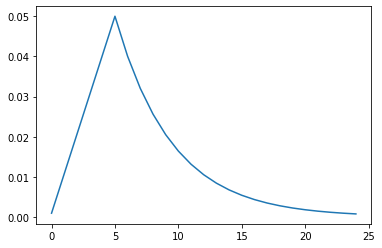

In [ ]:
# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.001  # 0.00001
LR_MAX = 0.05 * strategy.num_replicas_in_sync  # 0.00005
LR_MIN = 0.0001  # 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(25 if EPOCH<25 else EPOCH)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [ ]:
def compile_and_fit(resnet50,
                    ds_train,
                    ds_test,
                    ds_info,
                    learning_rate=0.01,
                    batch_size=16,
                    epochs=3):
                    
    resnet50.compile(
        loss='categorical_crossentropy',
        optimizer='sgd',
        metrics=['accuracy'],
    )

    history_resnet50 = resnet50.fit(
        ds_train, # augmentation 적용하지 않은 데이터셋 사용
        steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
        validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
        epochs=epochs,
        callbacks=[lr_callback],
        validation_data=ds_test,
        verbose=1,
        use_multiprocessing=True,
    )

    return history_resnet50

no augmentation

In [ ]:
history_resnet50_no_aug = compile_and_fit(
    resnet50_no_aug,
    ds_train_no_aug,
    ds_test,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/20
750/750 [==============================] - 54s 50ms/step - loss: 4.4327 - accuracy: 0.0798 - val_loss: 4.6391 - val_accuracy: 0.0539 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0108.
Epoch 2/20
750/750 [==============================] - 37s 49ms/step - loss: 1.7599 - accuracy: 0.5290 - val_loss: 1.7158 - val_accuracy: 0.5175 - lr: 0.0108

Epoch 3: LearningRateScheduler setting learning rate to 0.0206.
Epoch 3/20
750/750 [==============================] - 37s 49ms/step - loss: 1.0738 - accuracy: 0.6873 - val_loss: 1.9645 - val_accuracy: 0.4906 - lr: 0.0206

Epoch 4: LearningRateScheduler setting learning rate to 0.0304.
Epoch 4/20
750/750 [==============================] - 37s 49ms/step - loss: 0.9195 - accuracy: 0.7240 - val_loss: 2.8442 - val_accuracy: 0.3839 - lr: 0.0304

Epoch 5: LearningRateScheduler setting learning rate to 0.0402.
Epoch 5/20
750/750 [============================

augmentation

In [ ]:
history_resnet50_aug = compile_and_fit(
    resnet50_aug,
    ds_train_aug,
    ds_test,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/20
750/750 [==============================] - 43s 50ms/step - loss: 4.4640 - accuracy: 0.0704 - val_loss: 4.4741 - val_accuracy: 0.0662 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0108.
Epoch 2/20
750/750 [==============================] - 37s 49ms/step - loss: 1.8725 - accuracy: 0.5008 - val_loss: 1.7663 - val_accuracy: 0.5176 - lr: 0.0108

Epoch 3: LearningRateScheduler setting learning rate to 0.0206.
Epoch 3/20
750/750 [==============================] - 37s 49ms/step - loss: 1.2754 - accuracy: 0.6253 - val_loss: 2.2137 - val_accuracy: 0.4518 - lr: 0.0206

Epoch 4: LearningRateScheduler setting learning rate to 0.0304.
Epoch 4/20
750/750 [==============================] - 37s 49ms/step - loss: 1.1871 - accuracy: 0.6515 - val_loss: 2.2034 - val_accuracy: 0.4429 - lr: 0.0304

Epoch 5: LearningRateScheduler setting learning rate to 0.0402.
Epoch 5/20
750/750 [============================

Cutmix augmentation

In [ ]:
history_resnet50_aug_cutmix = compile_and_fit(
    resnet50_aug_cutmix,
    ds_train_aug_cutmix,
    ds_test,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/20
750/750 [==============================] - 45s 52ms/step - loss: 4.8958 - accuracy: 0.0182 - val_loss: 5.1493 - val_accuracy: 0.0138 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0108.
Epoch 2/20
750/750 [==============================] - 38s 51ms/step - loss: 3.6158 - accuracy: 0.2548 - val_loss: 1.8055 - val_accuracy: 0.5257 - lr: 0.0108

Epoch 3: LearningRateScheduler setting learning rate to 0.0206.
Epoch 3/20
750/750 [==============================] - 38s 50ms/step - loss: 3.0776 - accuracy: 0.3852 - val_loss: 1.6389 - val_accuracy: 0.5571 - lr: 0.0206

Epoch 4: LearningRateScheduler setting learning rate to 0.0304.
Epoch 4/20
750/750 [==============================] - 38s 50ms/step - loss: 2.8973 - accuracy: 0.4397 - val_loss: 1.9668 - val_accuracy: 0.4826 - lr: 0.0304

Epoch 5: LearningRateScheduler setting learning rate to 0.0402.
Epoch 5/20
750/750 [============================

Mixup

In [ ]:
history_resnet50_aug_mixup = compile_and_fit(
    resnet50_aug_mixup,
    ds_train_aug_mixup,
    ds_test,
    ds_info,
    LEARNING_RATE,
    BATCH_SIZE,
    EPOCH
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/20
750/750 [==============================] - 45s 52ms/step - loss: 4.8424 - accuracy: 0.0262 - val_loss: 5.2789 - val_accuracy: 0.0223 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0108.
Epoch 2/20
750/750 [==============================] - 38s 51ms/step - loss: 3.4777 - accuracy: 0.2954 - val_loss: 1.7608 - val_accuracy: 0.5255 - lr: 0.0108

Epoch 3: LearningRateScheduler setting learning rate to 0.0206.
Epoch 3/20
750/750 [==============================] - 38s 51ms/step - loss: 3.0217 - accuracy: 0.4223 - val_loss: 1.9465 - val_accuracy: 0.4895 - lr: 0.0206

Epoch 4: LearningRateScheduler setting learning rate to 0.0304.
Epoch 4/20
750/750 [==============================] - 38s 51ms/step - loss: 2.8549 - accuracy: 0.4715 - val_loss: 2.1483 - val_accuracy: 0.4598 - lr: 0.0304

Epoch 5: LearningRateScheduler setting learning rate to 0.0402.
Epoch 5/20
750/750 [============================

---
## 4. 훈련 과정 시각화하기
---
훈련 과정의 히스토리를 그래프로 시각화해 주세요.

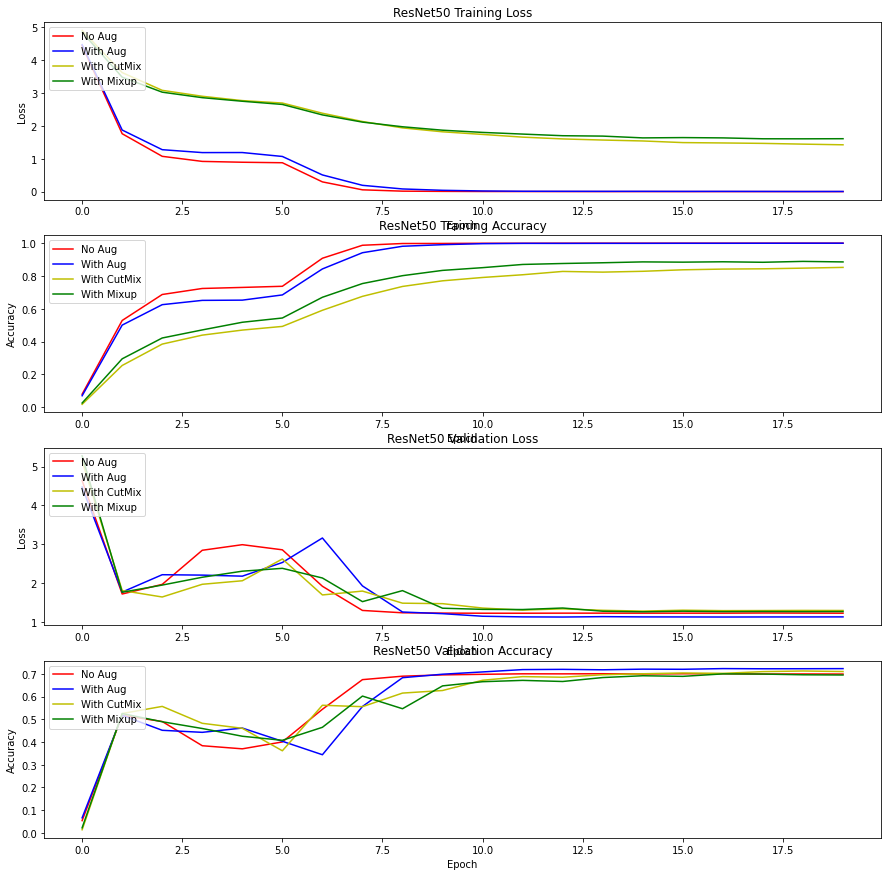

In [ ]:
plt.subplots(figsize=(15,15))

# No Aug, With Aug, With CutMix, With Mixup 의 Training Loss 시각화
plt.subplot(411)
plt.plot(history_resnet50_no_aug.history['loss'], 'r')
plt.plot(history_resnet50_aug.history['loss'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['loss'], 'y')
plt.plot(history_resnet50_aug_mixup.history['loss'], 'g')
plt.title('ResNet50 Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

# No Aug, With Aug, With CutMix, With Mixup 의 Training Accuracy 시각화
plt.subplot(412)
plt.plot(history_resnet50_no_aug.history['accuracy'], 'r')
plt.plot(history_resnet50_aug.history['accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['accuracy'], 'y')
plt.plot(history_resnet50_aug_mixup.history['accuracy'], 'g')
plt.title('ResNet50 Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

# No Aug, With Aug, With CutMix, With Mixup 의 Validation Loss 시각화
plt.subplot(413)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_loss'], 'y')
plt.plot(history_resnet50_aug_mixup.history['val_loss'], 'g')
plt.title('ResNet50 Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')

# No Aug, With Aug, With CutMix, With Mixup 의 Validation Accuracy 시각화
plt.subplot(414)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_aug_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_aug_mixup.history['val_accuracy'], 'g')
plt.title('ResNet50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Aug', 'With Aug', 'With CutMix', 'With Mixup'], loc='upper left')


---
## 5. Augmentation에 의한 모델 성능 비교
---
No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석해 보세요.

In [ ]:
def get_df_resnet50_result(col='val_accuracy'):
    # ResNet50 (No Aug, With Aug, With CutMix, With Mixup) 학습 결과 저장
    resnet50 = {
        'No Aug': history_resnet50_no_aug.history[col],
        'With Aug': history_resnet50_aug.history[col],
        'With CutMix': history_resnet50_aug_cutmix.history[col],
        'With Mixup': history_resnet50_aug_mixup.history[col]
    }

    # 데이터 프레임으로 생성
    df_resnet50 = pd.DataFrame(resnet50, index=[f'EPOCHS_{i}' for i in range(EPOCH)])
    return df_resnet50

In [ ]:
df_resnet50_loss = get_df_resnet50_result('loss')
df_resnet50_acc = get_df_resnet50_result('accuracy')
df_resnet50_val_loss = get_df_resnet50_result('val_loss')
df_resnet50_val_acc = get_df_resnet50_result('val_accuracy')

In [ ]:
# ResNet50 (No Aug, With Aug, With CutMix, With Mixup) 학습 결과 평균값을 딕셔너리로 저장
resnet50_result = {
    'loss': round(df_resnet50_loss.mean(),2),
    'accuracy': round(df_resnet50_acc.mean(),2),
    'val_losss': round(df_resnet50_val_loss.mean(),2),
    'val_accuracy': round(df_resnet50_val_acc.mean(),2),
}

# 데이터 프레임 생성
df_resnet50_result = pd.DataFrame(resnet50_result)
df_resnet50_result

,loss,accuracy,val_losss,val_accuracy
No Aug,0.52,0.87,1.74,0.59
With Aug,0.60,0.85,1.71,0.59
With CutMix,2.18,0.66,1.73,0.59
With Mixup,2.23,0.71,1.77,0.57


결과의 평균값을 봐서는 정확히 알 수 없기 때문에 아래 그래프를 다시 보기로 합니다.

---
## 6. Discussion
---
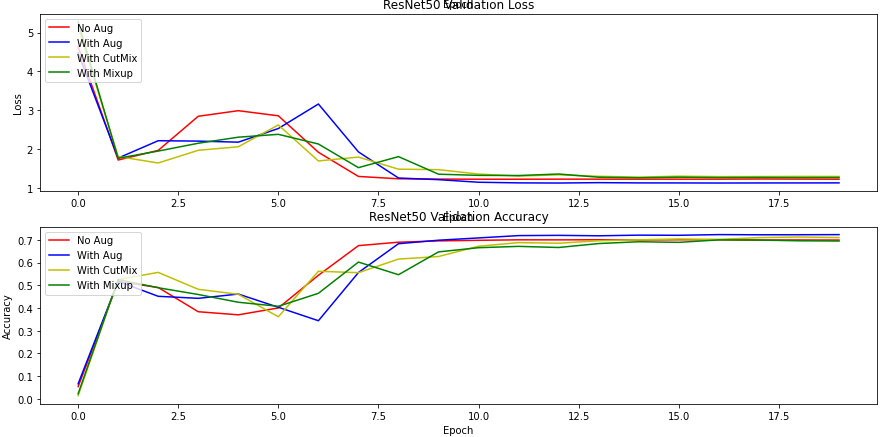

- Val. loss에 대해서는 아래와 같은 순서로
  - Augmentation - None - with Mixup - with Cutmix

- Val. accuracy에 대해서는 아래와 같은 순서로 성적을 확인했다.
  - Augmentation - with Cutmix - None - with Mixup

- 충분한 epochs를 통해 수렴한 후에는 Augmentation을 적용하지 않은 경우보다 적용 했을 때가 확실하게 높은 성능을 보여줬다.

- 하지만 Mixup이나 Cutmix와 같은 심화 기법을 적용하는 것이 무조건 우수한 성능을 가져오진 않는다는 것을 확인할 수 있었다.
  - mixup - 특정 비율로 픽셀별 값을 섞는 방식
  - cutmix - 일정 영역을 잘라서 붙여주는 방법

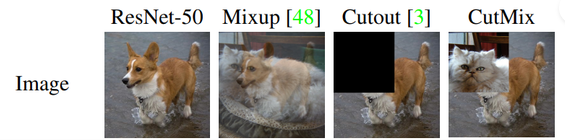

- 위의 이미지와 같이 원본의 이미지를 합치거나 수정하는 방식으로 이미지를 다양하게 만들 수 있지만, 마구 사용한다면 그 과정에서 판단에 중요한 부분의 정보가 소실 될 수도 있기 때문에, 이미지를 고려하여 적절하게 적용 할 필요가 있을 것 같다.
- Going deeper에서 배우는 내용들은 기존에 배운것들을 단순히 사용하기보다, 조금 더 근거있고 적절하게 사용하는 것이 훨씬 중요하다고 말하는 것 같다는 느낌을 받았다.
- 그리고 매 강좌가 이전의 foundation이나 exploration과는 달리 좀더 실전에 좀 더 가까운 내용이라서 흥미롭게 볼 수 있었다.

fin.